In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## O conjunto de dados

A base de dados utilizada será uma versão rotulada da base de dados disponível como material auxiliar do livro "Solomon, C., & Breckon, T. (2010). Fundamentals of Digital Image Processing. Wiley. https://doi.org/10.1002/9780470689776". A base de dados está disponível em https://www.fundipbook.com/materials/ e contém 141 imagens com garrafas que podem conter algum tipo de defeito. Entretanto, temos apenas 77 imagens rotuladas, logo, apenas essas serão utilizadas para avaliação.

As categorias de defeitos que existem no conjunto de dados são as seguintes:

* CONTENT_HIGH -> Líquido mais alto que o normal
* CONTENT_LOW -> Líquido mais baixo que o normal
* COVER_NONE -> Sem a tampa 
* BOTTLE_SMASHED -> Garrafa amassada
* LABEL_WHITE -> Rótulo em branco
* LABEL_MISPLACED -> Rótulo errado
* LABEL_NONE -> Rótulo vazio
* BOTTLE_NONE -> Garrafa inexistente


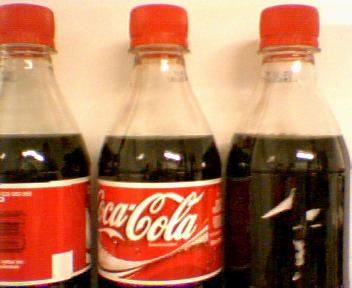

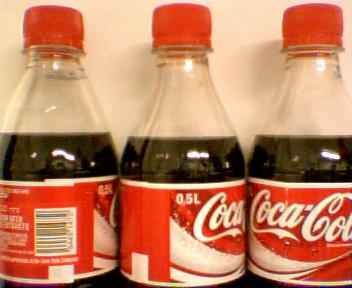

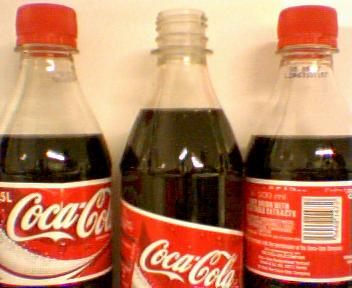

In [2]:
# Some of the images

from IPython.display import Image
from IPython.display import display

x = Image(filename='./bottles/train/train_1.jpg',width=224)
y = Image(filename='./bottles/train/train_2.jpg',width=224)
z = Image(filename='./bottles/train/train_3.jpg',width=224)
display(x,y,z)

In [3]:
# DataFrame with labels 

df = pd.read_csv('./train.csv')
df.head()


,filename,CONTENT_HIGH,CONTENT_LOW,COVER_NONE,BOTTLE_SMASHED,LABEL_WHITE,LABEL_MISPLACED,LABEL_NONE,BOTTLE_NONE
0,train_1.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,train_2.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,train_3.jpg,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN
3,train_4.jpg,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,train_5.jpg,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [4]:
df.columns

Index(['filename', 'CONTENT_HIGH', 'CONTENT_LOW', 'COVER_NONE',
       'BOTTLE_SMASHED', 'LABEL_WHITE', 'LABEL_MISPLACED', 'LABEL_NONE',
       'BOTTLE_NONE'],
      dtype='object')

## O projeto

O projeto envolve a classificação de garrafas defeituosas em uma linha de produção da Coca-Cola. A partir de diferentes imagens de garrafas em uma linha de produção, identificar se existe ou não algum tipo de defeito na garrafa, como a falta da marca, a garrafa estar vazia ou danificada, entre outros. O conjunto de dados é composto sempre por fotos de 3 garrafas, mas para este projeto sempre iremos avaliar a garrafa do meio. 

As categorias de defeito existentes no conjunto de dados, que serão o alvo da classificação, são:

* CONTENT_HIGH -> Líquido mais alto que o normal
* CONTENT_LOW -> Líquido mais baixo que o normal
* COVER_NONE -> Sem a tampa 
* BOTTLE_SMASHED -> Garrafa amassada
* LABEL_WHITE -> Rótulo em branco
* LABEL_MISPLACED -> Rótulo errado
* LABEL_NONE -> Rótulo vazio
* BOTTLE_NONE -> Garrafa inexistente


Como temos a rotulação correta das 77 imagens, a avaliação será por acurácia e matriz de confusão: quantas falhas ele conseguiu identificar corretamente. Para fins de sucesso mínimo, o algoritmo deverá ser capaz de superar um DummyClassifier, que neste dataset tem uma acurácia de 56%.


### Pré-processamento

Foram realizadas algumas etapas de pré-processamento. A primeira delas foi transformar o dataset que tínhamos com as rotulações em um DataFrame que pudesse ser aplicado em classificadores como o KNN e SVM.

Após isso, ajustes nas imagens como cortes para manter o foco na garrafa do centro, de modo que as garrafas laterais não influenciassem no resultado também foram realizados. Em conjunto, transformações para redimensionamento foram feitas.

Para fins de classificação, foram criados embeddings de imagens utilizando a seguinte ResNet: "". Os embbedings servirão de base para o classificador.

### Transformação do dataset


In [5]:
import pandas as pd
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('./train.csv')

# Transforming the train.csv to a classification problem
def transformToClassification(row):
    if row['CONTENT_HIGH'] == 1:
        return 'content_high'
    elif row['CONTENT_LOW'] == 1:
        return 'content_low'
    elif row['BOTTLE_SMASHED'] == 1:
        return 'bottle_smashed'
    elif row['LABEL_WHITE'] == 1:
        return 'label_white'
    elif row['LABEL_MISPLACED'] == 1:
        return 'label_misplaced'
    elif row['LABEL_NONE'] == 1:
        return 'label_none'
    elif row['BOTTLE_NONE'] == 1:
        return 'bottle_none'
    else:
        return 'normal'

df['class'] = df.apply(transformToClassification, axis=1)
result = df[['filename', 'class']]
print(result)

        filename           class
0    train_1.jpg          normal
1    train_2.jpg          normal
2    train_3.jpg    content_high
3    train_4.jpg    content_high
4    train_5.jpg    content_high
..           ...             ...
72  train_73.jpg          normal
73  train_74.jpg  bottle_smashed
74  train_75.jpg    content_high
75  train_76.jpg    content_high
76  train_77.jpg          normal

[77 rows x 2 columns]


### Embbedings e Ajustes das Imagens

In [6]:
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

import numpy as np

def cortar_centro(img, novo_tamanho):
    largura, altura = img.size
    nova_largura, nova_altura = novo_tamanho
    esquerda = (largura - nova_largura) // 2
    topo = (altura - nova_altura) // 2
    direita = esquerda + nova_largura
    fundo = topo + nova_altura
    return img.crop((esquerda, topo, direita, fundo))


def gerar_embeddings(arquivo_imagem):

    img = Image.open(arquivo_imagem)
    img_cortada = cortar_centro(img, (150, 255))
    img_transformada = Variable(normalize(to_tensor(scaler(img_cortada))).unsqueeze(0))

    embedding = torch.zeros(512) # armazenado espaço

    def capturar_embedding(m, i, o):
        embedding.copy_(o.data.reshape(o.data.size(1)))

    # capturando embeddings
    h = layer.register_forward_hook(capturar_embedding)
    model(img_transformada)

    h.remove()

    return np.array(embedding)


NameError: name 'transforms' is not defined

### Classificador

### KNN

Tal tal tal forma e X resultado

### CNN??

### Avaliação dos Resultados

## Pre processamento

Dos dados é transformar em tais coisas

da imagem é centralizar as fotos e mudar as cores

talvez fazer a centralizacao com o kmenas como no colab

In [220]:
# def normalizeAndCutImage(img):
#     # centralized = "" 

#     return 

image_2D = image.reshape(image.shape[0]*image.shape[1], image.shape[2])
import pandas as pd

pd.DataFrame(image_2D)

,0,1,2
0,0.984314,0.909804,0.784314
1,0.988235,0.913725,0.788235
2,0.988235,0.913725,0.788235
3,0.992157,0.917647,0.792157
4,0.992157,0.917647,0.792157
...,...,...,...
43195,0.137255,0.031373,0.000000
43196,0.133333,0.039216,0.000000
43197,0.129412,0.039216,0.007843
43198,0.133333,0.039216,0.023529


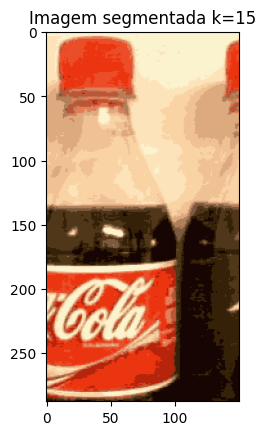

In [221]:
from sklearn.cluster import KMeans

num_segmentos = 15

kmeans = KMeans(n_clusters=num_segmentos, random_state=0).fit(image_2D)
clustered = kmeans.cluster_centers_[kmeans.labels_]

clustered_3D = clustered.reshape(image.shape[0], image.shape[1], image.shape[2])
plt.imshow(clustered_3D)
plt.title('Imagem segmentada k='+str(num_segmentos))
plt.show()

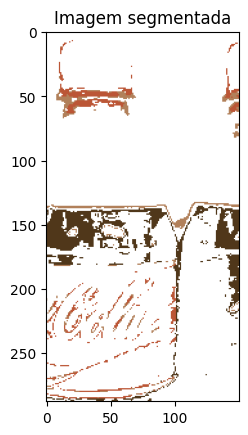

In [222]:
from sklearn.cluster import KMeans


segmentos_interesse = [0,6,14]

rgb_centers = kmeans.cluster_centers_*1
rgb_centers

for seg in kmeans.labels_:
  if seg not in segmentos_interesse:
    rgb_centers[seg] = [1,1,1]


clustered = rgb_centers[kmeans.labels_]

clustered_3D = clustered.reshape(image.shape[0], image.shape[1], image.shape[2])
plt.imshow(clustered_3D)
plt.title('Imagem segmentada')
plt.show()

## extração das features com embbeding de cnn

## knn

## avaliação

## Extração de Embbeddings


In [223]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

In [224]:
model = models.resnet18(pretrained=True)

layer = model._modules.get('avgpool')
model.eval() # coloca a rede em model eval() para desativar as dropout layers (sao uteis durante o treinamento apenas)

/home/felipe/code/usp/mineracao_dados/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/felipe/code/usp/mineracao_dados/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [225]:
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

import numpy as np

def cortar_centro(img, novo_tamanho):
    largura, altura = img.size
    nova_largura, nova_altura = novo_tamanho
    esquerda = (largura - nova_largura) // 2
    topo = (altura - nova_altura) // 2
    direita = esquerda + nova_largura
    fundo = topo + nova_altura
    return img.crop((esquerda, topo, direita, fundo))


def gerar_embeddings(arquivo_imagem):

    img = Image.open(arquivo_imagem)
    img_cortada = cortar_centro(img, (150, 255))
    img_transformada = Variable(normalize(to_tensor(scaler(img_cortada))).unsqueeze(0))

    embedding = torch.zeros(512) # armazenado espaço

    def capturar_embedding(m, i, o):
        embedding.copy_(o.data.reshape(o.data.size(1)))

    # capturando embeddings
    h = layer.register_forward_hook(capturar_embedding)
    model(img_transformada)

    h.remove()

    return np.array(embedding)



# im2 = gerar_embeddings("./bottles/train/train_2.jpg")
# im3 = gerar_embeddings("./bottles/train/train_1.jpg")

In [226]:

base_path = f"./bottles/train/"
result['embedding'] = result['filename'].apply(lambda x: gerar_embeddings(base_path+x))
result

/tmp/ipykernel_427593/1213602245.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return np.array(embedding)
/tmp/ipykernel_427593/2755130355.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['embedding'] = result['filename'].apply(lambda x: gerar_embeddings(base_path+x))


,filename,class,embedding
0,train_1.jpg,normal,"[0.2500936, 0.29862806, 0.8668492, 1.5010593, ..."
1,train_2.jpg,normal,"[0.034773987, 0.36840016, 1.0091888, 1.154968,..."
2,train_3.jpg,content_high,"[0.30469382, 0.88139266, 1.0159869, 1.1083338,..."
3,train_4.jpg,content_high,"[0.35833362, 0.520968, 0.32460353, 0.18693168,..."
4,train_5.jpg,content_high,"[0.11395779, 0.10551458, 0.1779632, 0.5547991,..."
...,...,...,...
72,train_73.jpg,normal,"[0.11126861, 0.28137904, 0.60515755, 1.2520286..."
73,train_74.jpg,bottle_smashed,"[0.25781953, 0.28069937, 0.26034412, 1.4017156..."
74,train_75.jpg,content_high,"[0.09230651, 0.21868706, 0.49398166, 1.2426761..."
75,train_76.jpg,content_high,"[0.3010686, 0.3601391, 0.78575563, 1.5109802, ..."


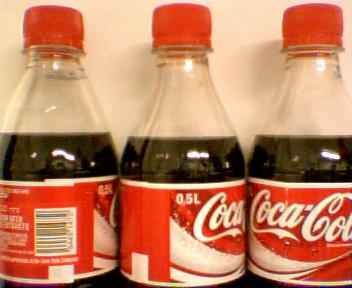

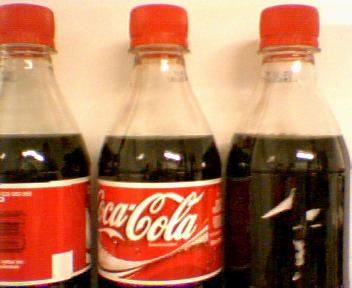

Dissimilaridade de Cosseno:  0.079897106


In [227]:
from IPython.display import Image
from IPython.display import display
from scipy.spatial import distance

x = Image(filename='./bottles/train/train_2.jpg',width=224)
y = Image(filename='./bottles/train/train_1.jpg',width=224)
display(x, y)

d_cos = distance.cosine(im2, im3) # dissimilaridade de cosseno
print('Dissimilaridade de Cosseno: ',d_cos)

In [228]:

from sklearn.model_selection import train_test_split


X = result.drop(columns=["class"])
y_target = result["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.3, random_state=42)
X_test


,filename,embedding
4,train_5.jpg,"[0.11395779, 0.10551458, 0.1779632, 0.5547991,..."
35,train_36.jpg,"[0.45943043, 0.5166473, 0.024825986, 1.3206279..."
10,train_11.jpg,"[0.23156357, 0.19898556, 0.099137045, 1.340282..."
0,train_1.jpg,"[0.2500936, 0.29862806, 0.8668492, 1.5010593, ..."
45,train_46.jpg,"[0.13341936, 0.25412455, 0.16626735, 1.393098,..."
47,train_48.jpg,"[0.16977225, 0.59450537, 0.44274116, 1.5264409..."
66,train_67.jpg,"[0.12451023, 1.111525, 0.15377462, 1.6547967, ..."
53,train_54.jpg,"[0.33028513, 0.28458732, 0.08989739, 0.7559834..."
50,train_51.jpg,"[0.3173561, 0.9211476, 1.3702902, 1.3368485, 0..."
28,train_29.jpg,"[0.10381253, 0.57205904, 0.20481305, 1.657373,..."


In [229]:

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3,metric="cosine")
knn.fit(np.array(X_train.embedding.to_list()), y_train)
y_pred = knn.predict(np.array(X_test.embedding.to_list()))
y_pred


array(['content_high', 'label_none', 'normal', 'normal', 'normal',
       'normal', 'content_high', 'label_none', 'content_high', 'normal',
       'normal', 'content_high', 'content_high', 'bottle_none',
       'bottle_none', 'content_high', 'content_high', 'content_high',
       'normal', 'content_high', 'normal', 'normal', 'label_white',
       'content_low'], dtype=object)

In [230]:

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 bottle_none       1.00      1.00      1.00         2
content_high       1.00      0.90      0.95        10
 content_low       1.00      0.50      0.67         2
  label_none       1.00      1.00      1.00         2
 label_white       1.00      1.00      1.00         1
      normal       0.78      1.00      0.88         7

    accuracy                           0.92        24
   macro avg       0.96      0.90      0.91        24
weighted avg       0.94      0.92      0.91        24



## CNN

In [238]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Definir as transformações
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Dividir o dataset em treino e teste de forma estratificada (preserva a distribuição de classes)
train_indices, test_indices = train_test_split(result, test_size=0.2, random_state=42)


# Criar Subsets para treino e teste
train_dataset = Subset(result, train_indices)
test_dataset = Subset(result, test_indices)

# Criar DataLoaders para treino e teste
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




In [232]:
# CNN de Classificação
class CNN_Classifier(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_Classifier, self).__init__()

        # Encoder (extrator de features)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # -> [16, 128, 128]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # -> [16, 64, 64]

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # -> [32, 64, 64]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # -> [32, 32, 32]

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # -> [64, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # -> [64, 16, 16]
        )

        # Camada fully connected para classificação
        self.fc = nn.Sequential(
            nn.Linear(64 * 16 * 16, 512),  # Reduzir as features para 512 dimensões (embeddings)
            nn.ReLU(),
            nn.Linear(512, num_classes)  # Camada final para classificação
        )

    def forward(self, x):
        # Extração de features
        x = self.encoder(x)
        x_flattened = x.view(x.size(0), -1)  # Achatar antes de passar pela camada fully connected

        # Embeddings intermediárias
        embeddings = self.fc[0](x_flattened)  # Obter as embeddings (saída da primeira camada fully connected)

        # Classificação
        out = self.fc[1](embeddings)  # Obter a classificação final

        return out, embeddings

# Definir dispositivo (GPU se disponível)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inicializar o modelo, critério de perda e otimizador
num_classes = len(result['class'])  # Número de classes baseado nos subdiretórios
model = CNN_Classifier(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [239]:
# Função para treinar o modelo
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            print(images)
            images, labels = images.to(device), labels.to(device)

            # Zerar os gradientes
            optimizer.zero_grad()

            # Forward pass
            outputs, _ = model(images)
            loss = criterion(outputs, labels)

            # Backward pass e otimização
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Treinar o modelo
train_model(model, train_loader, criterion, optimizer, device, num_epochs=50)


KeyError: 50

In [ ]:
from sklearn.metrics import classification_report

# Função para avaliar o modelo e gerar o classification report
def evaluate_model(model, test_loader, device):
    model.eval()  # Colocar o modelo em modo de avaliação
    y_pred = []
    y_true = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            _, preds = torch.max(outputs, 1)

            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Gerar o classification report
    report = classification_report(y_true, y_pred, target_names=dataset.classes)
    print(report)

# Avaliar o modelo e gerar o classification report
evaluate_model(model, test_loader, device)
